# Step 1 — Dataset Download

We use the **ISIC 2018 Lesion Segmentation Dataset** from the official ISIC Challenge.  

- **Task**: Segment skin lesions from dermoscopic images.  
- **Download**: [ISIC 2018 Challenge Data Page](https://challenge.isic-archive.com/data/#2018)  
  - **Training Input** (≈10.4 GB, skin images)  
  - **Training GroundTruth** (≈26 MB, mask images)  

⚠️ The images are very large because they are high-resolution `.jpg` files, while the masks are small grayscale `.png` files (just black and white).

# Step 2 — Dataset Check and Preview

## 2.1 Count files
We first check how many **images** and **masks** we have.  
This makes sure our folders are not empty.

In [16]:
# step 2.1: count files
import os, glob

project_root = os.getcwd()
img_dir = os.path.join(project_root, "data", "ISIC2018", "images")
msk_dir = os.path.join(project_root, "data", "ISIC2018", "masks")

img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
msk_paths = sorted(glob.glob(os.path.join(msk_dir, "*.png")))

print(f"# images: {len(img_paths)}")
print(f"# masks : {len(msk_paths)}")

assert len(img_paths) > 0 and len(msk_paths) > 0, "!!! Images or masks folder is empty! !!!"

# images: 2594
# masks : 2594


## 2.2 Match image with mask
Each image `ISIC_XXXXX.jpg` should have a mask  
`ISIC_XXXXX_segmentation.png`.  
We check if any image or mask is missing.

In [17]:
# step 2.2: match image with mask
import re

def base_id_from_image(p):
    return os.path.splitext(os.path.basename(p))[0]

def base_id_from_mask(p):
    name = os.path.splitext(os.path.basename(p))[0]
    return re.sub(r"_segmentation$", "", name)

img_ids = {base_id_from_image(p) for p in img_paths}
msk_ids = {base_id_from_mask(p) for p in msk_paths}

missing_masks = sorted(list(img_ids - msk_ids))
missing_images = sorted(list(msk_ids - img_ids))

print(f"images without masks: {len(missing_masks)}")
print(f"masks without images: {len(missing_images)}")

print("sample missing_masks: ", missing_masks[:5])
print("sample missing_images: ", missing_images[:5])

images without masks: 0
masks without images: 0
sample missing_masks:  []
sample missing_images:  []


## 2.3 Quick visual check
Show a few **image–mask pairs** to make sure they match.  
We also overlay the mask on the image in red for a sanity check.

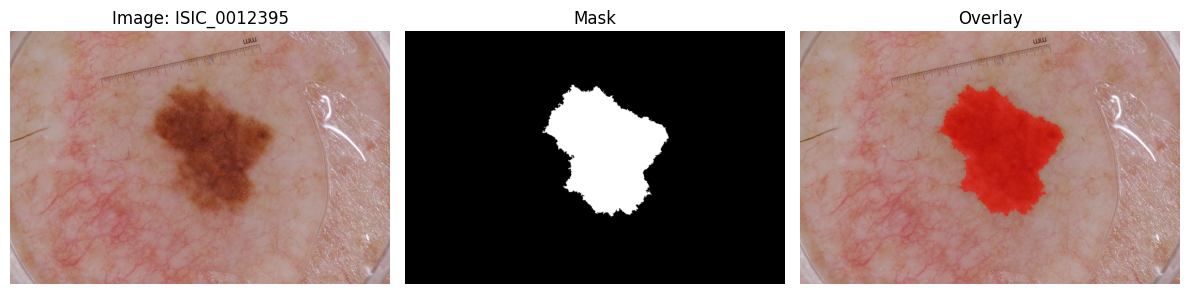

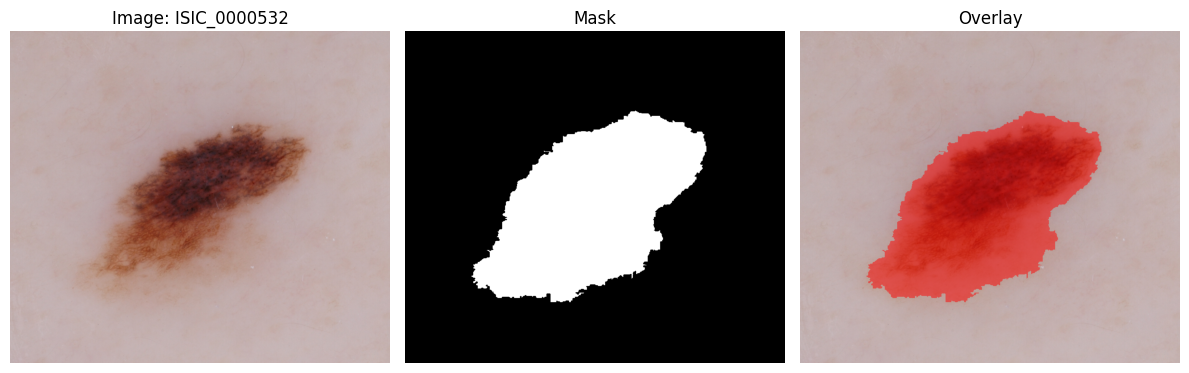

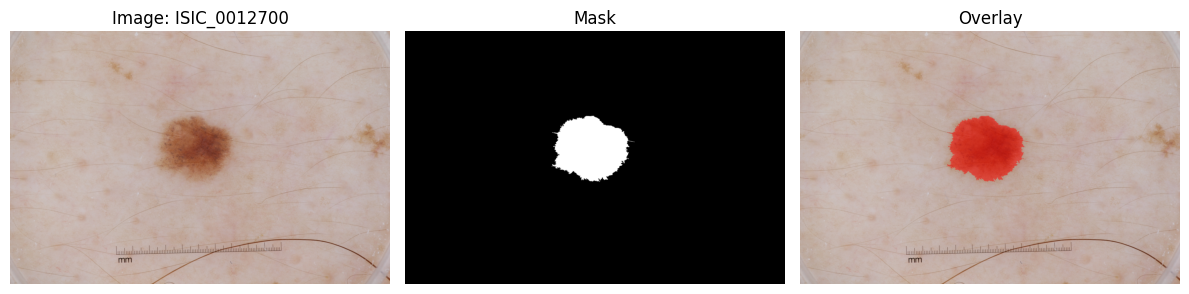

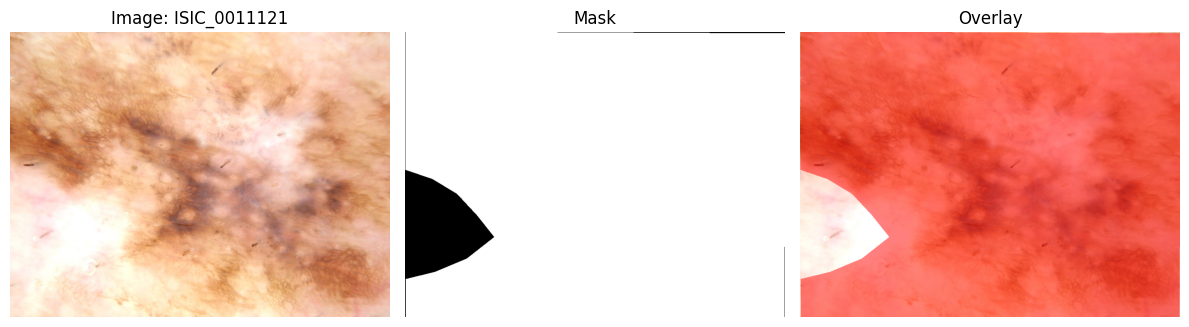

In [18]:
# step 2.3: visual sanity check
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Map ids to mask path
id_to_mask = {base_id_from_mask(p): p for p in msk_paths}
common_ids = sorted(list(img_ids & msk_ids))

sample_ids = random.sample(common_ids, k=min(4, len(common_ids)))

for sid in sample_ids:
    img_path = os.path.join(img_dir, f"{sid}.jpg")
    msk_path = id_to_mask[sid]

    img = Image.open(img_path).convert("RGB")
    msk = Image.open(msk_path).convert("L")

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img); axes[0].set_title(f"Image: {sid}"); axes[0].axis("off")
    axes[1].imshow(msk, cmap="gray"); axes[1].set_title("Mask"); axes[1].axis("off")

    img_np = np.array(img)
    msk_np = (np.array(msk) > 0).astype(np.uint8)
    overlay = img_np.copy()
    overlay[msk_np == 1] = overlay[msk_np == 1] * 0.5 + np.array([255, 0, 0]) * 0.5

    axes[2].imshow(overlay.astype(np.uint8)); axes[2].set_title("Overlay"); axes[2].axis("off")
    plt.tight_layout(); plt.show()

## 2.4 Image size
Check the **image sizes** to see what is most common.  
This helps us decide a good resize size for training.

In [47]:
# step 2.4: image size stats
from collections import Counter

sizes = []
sample_for_stats = min(300, len(img_paths))  # sample up to 300 images
for p in random.sample(img_paths, k=sample_for_stats):
    with Image.open(p) as im:
        sizes.append(im.size)  # (W, H)

cnt = Counter(sizes)
print("Most common WxH (top 5):")
for (w, h), c in cnt.most_common(5):
    print(f"  {w}x{h}: {c} samples")

avg_w = int(np.mean([w for (w, h) in sizes]))
avg_h = int(np.mean([h for (w, h) in sizes]))
print(f"Average size: {avg_w}x{avg_h}")

# Recommendation: use 256*256 (fast) or 384*384 (better detail) for training."

Most common WxH (top 5):
  4288x2848: 66 samples
  1024x768: 59 samples
  3008x2000: 42 samples
  3024x2016: 16 samples
  3872x2592: 14 samples
Average size: 3195x2173


# Step 3 — Train/Validation Split & Preprocessing

## 3.1 Choose image size
We will resize all images and masks to a fixed square size.  
- Start with **256×256** for faster training.  

In [20]:
# step 3.1: parameters
import tensorflow as tf

IMAGE_SIZE   = 256
BATCH_SIZE   = 8
VAL_FRACTION = 0.2
SEED         = 42
IMG_SIZE     = (IMAGE_SIZE, IMAGE_SIZE)
AUTOTUNE     = tf.data.AUTOTUNE

## 3.2 Make a reproducible split
Create an **80/20** split (train/val).  
We only keep samples that have **both** an image and a mask.

In [21]:
# step 3.2: train/validation split
import random, os, re, glob

def base_id_from_image(p): 
    return os.path.splitext(os.path.basename(p))[0]

def base_id_from_mask(p):
    name = os.path.splitext(os.path.basename(p))[0]
    return re.sub(r"_segmentation$", "", name)

img_paths = sorted(glob.glob("data/ISIC2018/images/*.jpg"))
msk_paths = sorted(glob.glob("data/ISIC2018/masks/*.png"))

img_map = {base_id_from_image(p): p for p in img_paths}
msk_map = {base_id_from_mask(p): p for p in msk_paths}

common_ids = sorted(list(set(img_map.keys()) & set(msk_map.keys())))
pairs = [(img_map[i], msk_map[i]) for i in common_ids]
print(f"Total paired samples: {len(pairs)}")

random.Random(SEED).shuffle(pairs)
n_val = int(len(pairs) * VAL_FRACTION)
val_pairs = pairs[:n_val]
train_pairs = pairs[n_val:]
print(f"Train: {len(train_pairs)} | Val: {len(val_pairs)}")

Total paired samples: 2594
Train: 2076 | Val: 518


## 3.3 Preprocess the data
For each image and mask:  
- Load from disk  
- Resize to `(256, 256)`  
- Normalize image to `[0,1]`  
- Binarize mask to `{0,1}` with shape `(H,W,1)`

In [22]:
# step 3.3: preprocessing functions
@tf.function
def load_image(path):
    b = tf.io.read_file(path)
    return tf.io.decode_jpeg(b, channels=3)

@tf.function
def load_mask(path):
    b = tf.io.read_file(path)
    return tf.io.decode_png(b, channels=1)

@tf.function
def preprocess(img_path, msk_path):
    img = load_image(img_path)
    msk = load_mask(msk_path)

    img = tf.image.resize(img, IMG_SIZE, method="bilinear")
    msk = tf.image.resize(msk, IMG_SIZE, method="nearest")

    img = tf.cast(img, tf.float32) / 255.0
    msk = tf.cast(msk > 0, tf.float32)
    return img, msk

## 3.4 Build the data pipeline
We create efficient datasets for training and validation:
- Shuffle training data  
- Apply preprocessing (+ light augmentation for training)  
- Batch, cache, and prefetch

In [23]:
# step 3.4: dataset pipelines
@tf.function
def augment(img, msk):
    do_flip = tf.random.uniform(()) > 0.5
    img = tf.cond(do_flip, lambda: tf.image.flip_left_right(img), lambda: img)
    msk = tf.cond(do_flip, lambda: tf.image.flip_left_right(msk), lambda: msk)
    return img, msk

def make_ds(pairs, training=False, batch_size=BATCH_SIZE):
    img_p = [p[0] for p in pairs]
    msk_p = [p[1] for p in pairs]
    ds = tf.data.Dataset.from_tensor_slices((img_p, msk_p))
    if training:
        ds = ds.shuffle(buffer_size=len(pairs), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).cache().prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_pairs, training=True)
val_ds   = make_ds(val_pairs, training=False)

## 3.5 Quick preview
Visualize a few training samples:  
- Image  
- Ground Truth mask  
- Overlay (mask on top of image)

2025-09-06 09:42:11.790473: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


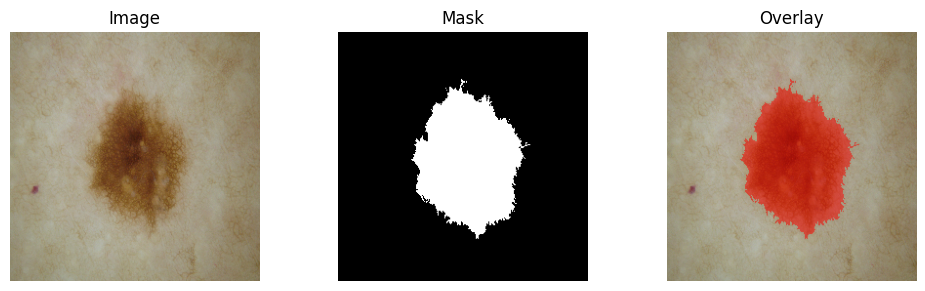

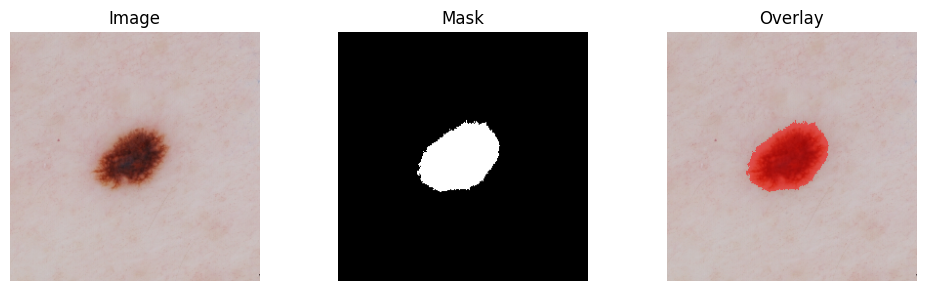

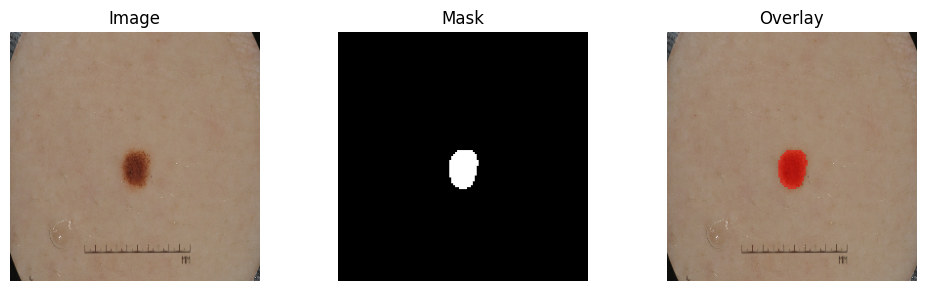

In [24]:
# step 3.5: preview batch
import matplotlib.pyplot as plt
import numpy as np

def show_batch(dataset, n=3):
    imgs, msks = next(iter(dataset))
    n = min(n, imgs.shape[0])
    for i in range(n):
        img = imgs[i].numpy()
        msk = msks[i].numpy()
        overlay = img.copy()
        overlay[msk[..., 0] > 0.5] = 0.5 * overlay[msk[..., 0] > 0.5] + 0.5 * np.array([1.0, 0.0, 0.0])

        fig, axes = plt.subplots(1, 3, figsize=(10, 3))
        axes[0].imshow(img); axes[0].set_title("Image"); axes[0].axis("off")
        axes[1].imshow(msk[..., 0], cmap="gray"); axes[1].set_title("Mask"); axes[1].axis("off")
        axes[2].imshow(overlay); axes[2].set_title("Overlay"); axes[2].axis("off")
        plt.tight_layout(); plt.show()

show_batch(train_ds, n=3)

# Step 4 — Baseline Model (U-Net, Keras/TensorFlow)

## 4.1 Metrics & losses
We will track **Dice** and **IoU (Jaccard)**.

In [25]:
# step 4.1: Metrics & losses
import tensorflow as tf

@tf.function
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

@tf.function
def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

@tf.function
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

## 4.2 Build a small U-Net
A lightweight U-Net that works well at **256×256**.

In [26]:
# step 4.2: U-Net builder
from keras import layers, models

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(img_size=256):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)
    bn = conv_block(p4, 512)
    d4 = decoder_block(bn, c4, 256)
    d3 = decoder_block(d4, c3, 128)
    d2 = decoder_block(d3, c2, 64)
    d1 = decoder_block(d2, c1, 32)
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d1)
    model = models.Model(inputs, outputs, name="UNet_baseline")
    return model

## 4.3 Compile the model
- Optimizer: **Adam (1e-3)**
- Loss: **Binary Cross Entropy**
- Metrics: **Dice** and **IoU**

In [27]:
# step 4.3: Compile
IMAGE_SIZE = 256  # keep same as Step 3
model = build_unet(img_size=IMAGE_SIZE)
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[dice_coef, iou_coef]
)
model.summary()

Model: "UNet_baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_19[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_21[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_23[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_25[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_27[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 32, 32,    │          0 │ conv2d_28[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ up_sampling2d_4[

 Total params: 7,846,657 (29.93 MB)

 Trainable params: 7,846,657 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

## 4.4 Callbacks
- Save best by **val_dice_coef**
- Reduce LR on plateau
- Early stopping

In [28]:
# step 4.4: Callbacks
import os
from keras import callbacks

os.makedirs("models", exist_ok=True)

checkpoint = callbacks.ModelCheckpoint(
    "models/unet_baseline_best.h5",
    monitor="val_dice_coef",
    mode="max",
    save_best_only=True,
    verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_dice_coef",
    mode="max",
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)
early_stop = callbacks.EarlyStopping(
    monitor="val_dice_coef",
    mode="max",
    patience=8,
    restore_best_weights=True,
    verbose=1
)
cbs = [checkpoint, reduce_lr, early_stop]

## 4.5 Train the model
Start with **6 epochs** and **batch size 8**.  
(You can increase later if training looks stable.)

In [ ]:
# step 4.5: trainning

# In this case we will use QUICK traning
EPOCHS = 6
STEPS_PER_EPOCH = 120      # lower = faster; try 80–150
VAL_STEPS = 40             # lower = faster; try 30–60

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,   # <-- cap train batches
    validation_steps=VAL_STEPS,        # <-- cap val batches
    callbacks=cbs,
    verbose=1
)

Epoch 1/6
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - dice_coef: 0.4455 - iou_coef: 0.2919 - loss: 0.3638
Epoch 1: val_dice_coef improved from 0.46263 to 0.49095, saving model to models/unet_baseline_best.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 565s 5s/step - dice_coef: 0.4455 - iou_coef: 0.2919 - loss: 0.3639 - val_dice_coef: 0.4910 - val_iou_coef: 0.3288 - val_loss: 0.3721 - learning_rate: 0.0010
Epoch 2/6
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - dice_coef: 0.4441 - iou_coef: 0.2887 - loss: 0.3876
Epoch 2: val_dice_coef did not improve from 0.49095
120/120 ━━━━━━━━━━━━━━━━━━━━ 542s 5s/step - dice_coef: 0.4441 - iou_coef: 0.2887 - loss: 0.3875 - val_dice_coef: 0.4340 - val_iou_coef: 0.2801 - val_loss: 0.4155 - learning_rate: 0.0010
Epoch 3/6
 20/120 ━━━━━━━━━━━━━━━━━━━━ 7:00 4s/step - dice_coef: 0.4762 - iou_coef: 0.3149 - loss: 0.4180

/opt/anaconda3/envs/tf311/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 3: val_dice_coef did not improve from 0.49095
120/120 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - dice_coef: 0.4621 - iou_coef: 0.3032 - loss: 0.4039 - val_dice_coef: 0.4872 - val_iou_coef: 0.3257 - val_loss: 0.3762 - learning_rate: 0.0010
Epoch 4/6
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - dice_coef: 0.4492 - iou_coef: 0.2975 - loss: 0.4015
Epoch 4: val_dice_coef did not improve from 0.49095

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
120/120 ━━━━━━━━━━━━━━━━━━━━ 491s 4s/step - dice_coef: 0.4489 - iou_coef: 0.2973 - loss: 0.4016 - val_dice_coef: 0.3080 - val_iou_coef: 0.1829 - val_loss: 0.4316 - learning_rate: 0.0010
Epoch 5/6
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - dice_coef: 0.3353 - iou_coef: 0.2033 - loss: 0.4204
Epoch 5: val_dice_coef improved from 0.49095 to 0.50545, saving model to models/unet_baseline_best.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 476s 4s/step - dice_coef: 0.3356 - iou_coef: 0.2036 - loss: 0.4201 - val_dice_coef: 0.5054 - val_iou_coef: 0.3410 - val_loss: 0.3739 - learning_rate: 5.0000e-04
Epoch 6/6
 20/120 ━━━━━━━━━━━━━━━━━━━━ 8:26 5s/step - dice_coef: 0.5323 - iou_coef: 0.3649 - loss: 0.3727
Epoch 6: val_dice_coef improved from 0.50545 to 0.51626, saving model to models/unet_baseline_best.h5


120/120 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - dice_coef: 0.5257 - iou_coef: 0.3592 - loss: 0.3585 - val_dice_coef: 0.5163 - val_iou_coef: 0.3504 - val_loss: 0.3351 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 6.


## 4.6 Evaluate on validation set
Print validation **Loss**, **Dice**, and **IoU**.

In [31]:
# step 4.6: evaluate
val_metrics = model.evaluate(val_ds, return_dict=True)
print("Validation metrics:", val_metrics)

65/65 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - dice_coef: 0.5128 - iou_coef: 0.3470 - loss: 0.3284
Validation metrics: {'dice_coef': 0.5189230442047119, 'iou_coef': 0.3536708652973175, 'loss': 0.32338741421699524}


## 4.7 Visual check of predictions
Show **Image**, **GT mask**, **Predicted mask**, and an **Overlay**.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step


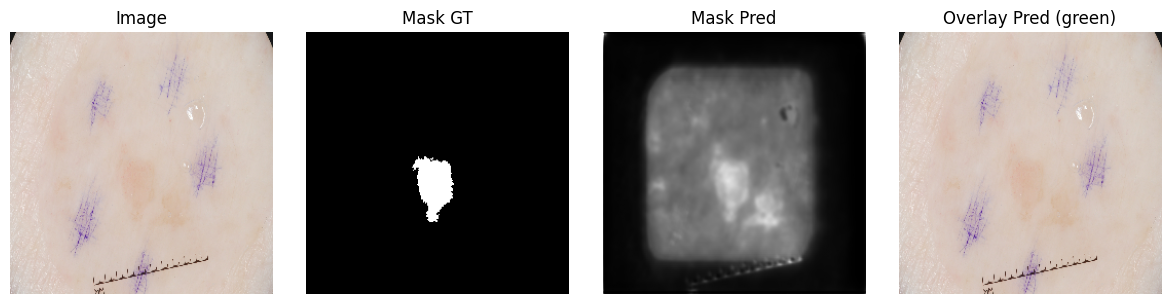

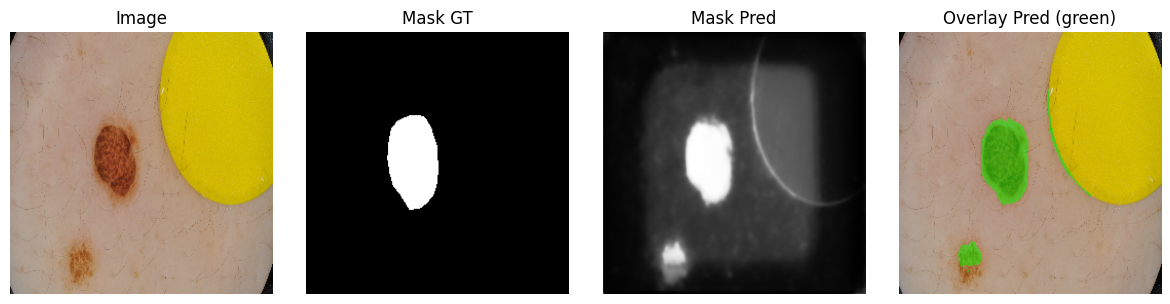

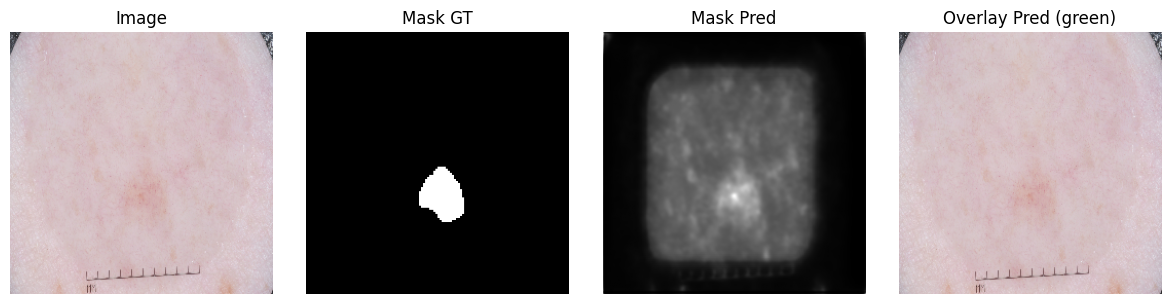

In [32]:
# step 4.7: Visualize predictions
import matplotlib.pyplot as plt
import numpy as np

def predict_and_show(dataset, n=3, threshold=0.5):
    imgs, msks = next(iter(dataset))
    preds = model.predict(imgs)
    n = min(n, imgs.shape[0])
    for i in range(n):
        img = imgs[i].numpy()
        msk = msks[i].numpy()[..., 0]
        pred = preds[i, ..., 0]
        pred_bin = (pred > threshold).astype(np.float32)

        overlay_pred = img.copy()
        overlay_pred[pred_bin > 0.5] = 0.5 * overlay_pred[pred_bin > 0.5] + 0.5 * np.array([0.0, 1.0, 0.0])

        fig, axes = plt.subplots(1, 4, figsize=(12, 3))
        axes[0].imshow(img); axes[0].set_title("Image"); axes[0].axis("off")
        axes[1].imshow(msk, cmap="gray"); axes[1].set_title("Mask GT"); axes[1].axis("off")
        axes[2].imshow(pred, cmap="gray"); axes[2].set_title("Mask Pred"); axes[2].axis("off")
        axes[3].imshow(overlay_pred); axes[3].set_title("Overlay Pred (green)"); axes[3].axis("off")
        plt.tight_layout(); plt.show()

predict_and_show(val_ds, n=3)

## 4.8 Save a few predicted masks
We save some predicted masks (binary PNG) for the report.

In [33]:
# step 4.8: save sample predictions
import os
from PIL import Image
os.makedirs("outputs/preds", exist_ok=True)

def save_some_predictions(dataset, count=10, threshold=0.5):
    saved = 0
    for imgs, _ in dataset:
        preds = model.predict(imgs)
        for i in range(imgs.shape[0]):
            if saved >= count:
                return
            pred = (preds[i, ..., 0] > threshold).astype("uint8") * 255
            Image.fromarray(pred).save(f"outputs/preds/pred_{saved:03d}.png")
            saved += 1

save_some_predictions(val_ds, count=10)
print("Saved example predictions to outputs/preds/")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
Saved example predictions to outputs/preds/


# Step 5 — Learning Curves & Error Analysis

## 5.1 Plot training curves
Show how **Loss**, **Dice**, and **IoU** changed over epochs for train/val.  
This helps check for:
- Underfitting (both low)  
- Overfitting (train high, val low)  
- Balanced training (curves close together)

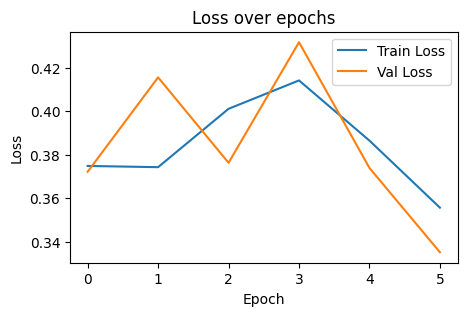

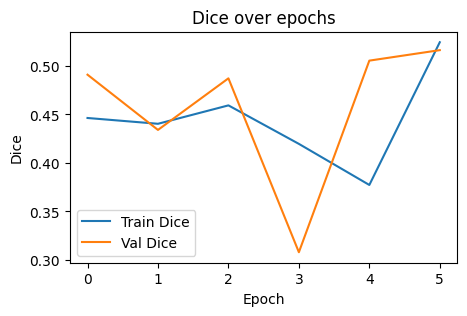

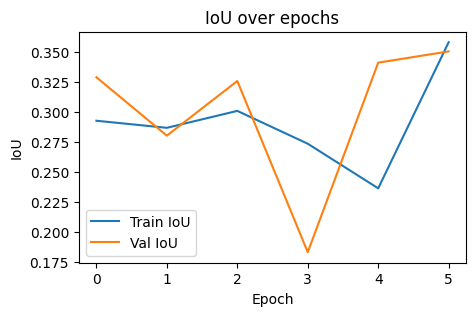

In [34]:
# step 5.1: plot learning curves
import matplotlib.pyplot as plt

def plot_history(history):
    hist = history.history
    metrics = [("loss", "Loss"), ("dice_coef", "Dice"), ("iou_coef", "IoU")]

    for key, label in metrics:
        if key in hist:
            plt.figure(figsize=(5,3))
            plt.plot(hist[key], label=f"Train {label}")
            plt.plot(hist["val_" + key], label=f"Val {label}")
            plt.xlabel("Epoch"); plt.ylabel(label)
            plt.legend(); plt.title(f"{label} over epochs")
            plt.show()

plot_history(history)

## 5.2 Check best vs worst validation samples
- Look at a few **good** (high Dice) predictions.  
- Look at a few **bad** (low Dice) predictions.  
This helps you see **failure modes** (e.g., fuzzy boundaries, small lesions).

In [35]:
# step 5.2: evaluate sample Dice per image
import numpy as np

def dice_score_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

scores = []
imgs_all, msks_all = [], []

for imgs, msks in val_ds:
    preds = model.predict(imgs)
    for i in range(imgs.shape[0]):
        img, msk, pred = imgs[i].numpy(), msks[i].numpy()[...,0], preds[i,...,0]
        pred_bin = (pred > 0.5).astype(np.float32)
        score = dice_score_np(msk, pred_bin)
        scores.append((score, img, msk, pred))
    break  # only first batch for quick check

scores_sorted = sorted(scores, key=lambda x: x[0])
print("Best Dice:", scores_sorted[-1][0])
print("Worst Dice:", scores_sorted[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Best Dice: 0.8572808
Worst Dice: 6.067961e-10


## 5.3 Visualize best and worst cases
Overlay predictions in green and ground truth in red.  
Helps you see where the model does well or fails.

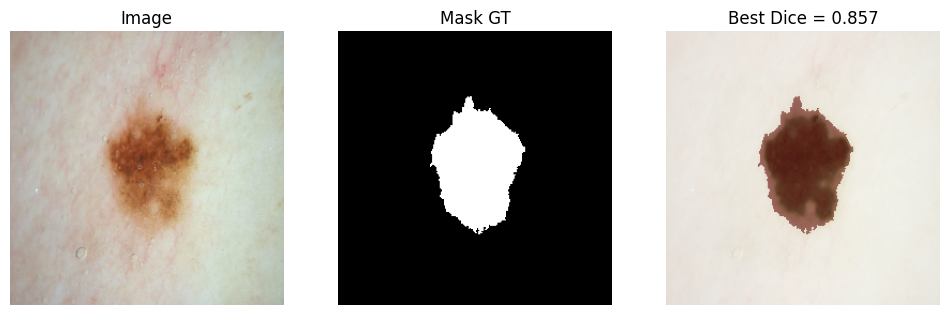

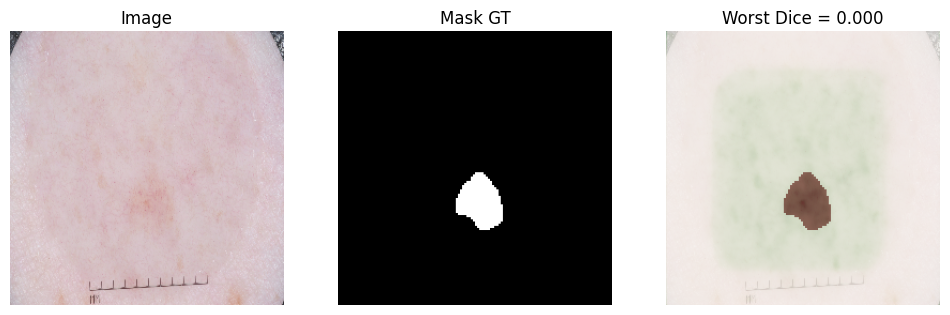

In [36]:
# Step 5.3: show best and worst cases
def show_case(img, msk, pred, title):
    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(img); axes[0].set_title("Image"); axes[0].axis("off")
    axes[1].imshow(msk, cmap="gray"); axes[1].set_title("Mask GT"); axes[1].axis("off")
    axes[2].imshow(img); axes[2].imshow(pred, cmap="Greens", alpha=0.5)
    axes[2].imshow(msk, cmap="Reds", alpha=0.5)
    axes[2].set_title(title); axes[2].axis("off")
    plt.show()

best = scores_sorted[-1]
worst = scores_sorted[0]

show_case(best[1], best[2], best[3], f"Best Dice = {best[0]:.3f}")
show_case(worst[1], worst[2], worst[3], f"Worst Dice = {worst[0]:.3f}")

## 5.4 Discussion
- If train Dice >> val Dice -> overfitting.  
- If both low -> model too weak, need bigger U-Net, more epochs, or better augmentations.  
- Check typical failure cases:
  - Small or faint lesions -> model misses them.  
  - Hair/artifacts -> confuse the model.  
  - Irregular borders -> harder to segment.

# Step 6 — Advanced Model + Comparison
We’ll train a stronger model (**DeepLabV3+ with MobileNetV2 backbone**) and compare it with the baseline U-Net.

**Why DeepLabV3+?**
- Uses **dilated convolutions** and **ASPP** to capture context.
- Decoder refines details using a **low-level skip** (like U-Net).

## 6.1 Plan
- Keep the same input size (**256×256**).
- Build **DeepLabV3+ (MobileNetV2)**.
- Train for ~**10–15 epochs**.
- Compare **Val Dice** and **Val IoU** vs the baseline.

In [ ]:
# step 6.1: setup shared bits
import tensorflow as tf
from keras import layers, models

IMG_SIZE = (IMAGE_SIZE, IMAGE_SIZE)  # from step 3.1

## 6.2 Build DeepLabV3+ (MobileNetV2)
- Use a safe **ASPP** implementation:
  - Global pooling branch uses `tf.reduce_mean(..., keepdims=True)`
  - Upsample with `tf.image.resize` to match the backbone feature map
- No reliance on static shapes

In [ ]:
# step 6.2 : DeepLabV3+ (MobileNetV2) backbone with safe dynamic resize
import tensorflow as tf
from keras import layers, models

def conv_bn_relu(x, filters, k=3, s=1, d=1):
    x = layers.Conv2D(filters, k, strides=s, padding="same",
                      dilation_rate=d, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def resize_to_ref(src, ref):
    """Resize `src` to match spatial size of `ref` at runtime (bilinear).
       Uses Lambda with explicit output_shape to satisfy Keras shape inference."""
    def _resize(tensors):
        s, r = tensors
        size = tf.shape(r)[1:3]  # dynamic [H,W] of ref
        return tf.image.resize(s, size, method="bilinear")
    def _outshape(shapes):
        s_shape, r_shape = shapes  # (B, hs, ws, Cs), (B, hr, wr, Cr)
        # batch dim stays same; spatial copied from ref; channels from src
        return (s_shape[0], r_shape[1], r_shape[2], s_shape[3])
    return layers.Lambda(_resize, output_shape=_outshape)([src, ref])

def aspp(x, filters=256, rates=(6, 12, 18)):
    # Global pooling branch
    y_pool = layers.Lambda(lambda t: tf.reduce_mean(t, axis=[1, 2], keepdims=True))(x)
    y_pool = conv_bn_relu(y_pool, filters, k=1)
    y_pool = resize_to_ref(y_pool, x)  # upsample pooled vector back to feature map size

    # 1×1 conv branch
    y_1x1 = conv_bn_relu(x, filters, k=1)

    # 3×3 dilated branches
    y_d1 = conv_bn_relu(x, filters, k=3, d=rates[0])
    y_d2 = conv_bn_relu(x, filters, k=3, d=rates[1])
    y_d3 = conv_bn_relu(x, filters, k=3, d=rates[2])

    y = layers.Concatenate()([y_pool, y_1x1, y_d1, y_d2, y_d3])
    y = conv_bn_relu(y, filters, k=1)
    return y

def build_deeplabv3plus(img_size=256, num_classes=1):
    inputs = layers.Input(shape=(img_size, img_size, 3))

    # IMPORTANT: preprocess inputs for MobileNetV2 (expects [-1, 1])
    x_in = layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input)(inputs)

    # MobileNetV2 backbone (ImageNet)
    base = tf.keras.applications.MobileNetV2(
        input_tensor=x_in, include_top=False, weights="imagenet", alpha=1.0
    )
    # Low-level (stride 4) and high-level (stride 16) features
    low_level    = base.get_layer("block_3_expand_relu").output   # stride 4
    backbone_out = base.get_layer("block_13_expand_relu").output  # stride 16

    # ASPP on high-level features
    x = aspp(backbone_out, filters=256, rates=(6, 12, 18))

    # Upsample ASPP output 16→4 to match low-level (static factor is safe here)
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    # Project low-level
    low = conv_bn_relu(low_level, 48, k=1)

    # Fuse & refine
    x = layers.Concatenate()([x, low])
    x = conv_bn_relu(x, 256)
    x = conv_bn_relu(x, 256)

    # Upsample 4→1 (input scale)
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    # Prediction head
    outputs = layers.Conv2D(num_classes, 1, activation="sigmoid")(x)

    return models.Model(inputs, outputs, name="DeepLabV3plus_MobileNetV2")

# Build & inspect
dlv3p = build_deeplabv3plus(img_size=IMAGE_SIZE, num_classes=1)
dlv3p.summary()

/var/folders/js/jm7x373s1_sdh24h5xppp_s80000gn/T/ipykernel_56847/1187163178.py:50: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


Model: "DeepLabV3plus_MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 256, 256,  │          0 │ input_layer_5[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ lambda_5[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis

 Total params: 6,525,953 (24.89 MB)

 Trainable params: 6,504,481 (24.81 MB)

 Non-trainable params: 21,472 (83.88 KB)

## 6.3 Compile DeepLabV3+
Use the same loss/metrics as the baseline for a fair comparison.

In [42]:
# step 6.3: compile DeepLabV3+
dlv3p.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[dice_coef, iou_coef]
)

## 6.4 Train DeepLabV3+
- Start with **6 epochs** for a quick training
- Use the same `train_ds` and `val_ds`

In [44]:
# step 6.4 (QUICK): train DeepLabV3+ with half steps
EPOCHS_ADV = 6
STEPS_PER_EPOCH = 60    # cap training steps (half of a typical 120–150)
VAL_STEPS = 20          # cap validation steps

history_dlv3p = dlv3p.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_ADV,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            "models/dlv3p_best.h5", monitor="val_dice_coef", mode="max",
            save_best_only=True, verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_dice_coef", mode="max", factor=0.5,
            patience=3, min_lr=1e-6, verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_dice_coef", mode="max",
            patience=3, restore_best_weights=True, verbose=1
        )
    ]
)

Epoch 1/6
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice_coef: 0.6704 - iou_coef: 0.5093 - loss: 0.2472
Epoch 1: val_dice_coef improved from -inf to 0.47111, saving model to models/dlv3p_best.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - dice_coef: 0.6711 - iou_coef: 0.5102 - loss: 0.2466 - val_dice_coef: 0.4711 - val_iou_coef: 0.3106 - val_loss: 1.1214 - learning_rate: 0.0010
Epoch 2/6
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - dice_coef: 0.7464 - iou_coef: 0.6021 - loss: 0.1881
Epoch 2: val_dice_coef did not improve from 0.47111
60/60 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step - dice_coef: 0.7465 - iou_coef: 0.6022 - loss: 0.1879 - val_dice_coef: 0.4669 - val_iou_coef: 0.3063 - val_loss: 0.7498 - learning_rate: 0.0010
Epoch 3/6
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - dice_coef: 0.7848 - iou_coef: 0.6499 - loss: 0.1673
Epoch 3: val_dice_coef did not improve from 0.47111
60/60 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - dice_coef: 0.7846 - iou_coef: 0.6496 - loss: 0.1673 - val_dice_coef: 0.4250 - val_iou_coef: 0.2705 - val_loss: 0.4750 - learning_rate: 0.0010
Epoch 4/6
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_coef: 0.7714 - iou_coef: 0.6332 - loss: 0.1610 
Epoch 4: val_dice_coef did not impro

## 6.5 Evaluate and compare
We compare **Val Dice** and **Val IoU (Jaccard)** between:
- Baseline **U-Net** (`model`)
- **DeepLabV3+** (`dlv3p`)

Baseline U-Net: {'dice_coef': 0.5189230442047119, 'iou_coef': 0.3536708652973175, 'loss': 0.32338741421699524}
DeepLabV3+   : {'dice_coef': 0.48956286907196045, 'iou_coef': 0.3294012248516083, 'loss': 1.0606238842010498}


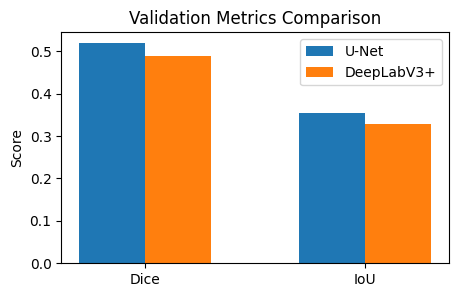

In [45]:
# step 6.5: evaluate & compare
val_base = model.evaluate(val_ds, return_dict=True, verbose=0)
val_dlv3 = dlv3p.evaluate(val_ds, return_dict=True, verbose=0)

print("Baseline U-Net:", val_base)
print("DeepLabV3+   :", val_dlv3)

# simple comparison plot
import matplotlib.pyplot as plt

labels = ["Dice", "IoU"]
base_scores = [val_base.get("dice_coef", 0), val_base.get("iou_coef", 0)]
dlv3_scores = [val_dlv3.get("dice_coef", 0), val_dlv3.get("iou_coef", 0)]

x = range(len(labels))
plt.figure(figsize=(5,3))
plt.bar([i-0.15 for i in x], base_scores, width=0.3, label="U-Net")
plt.bar([i+0.15 for i in x], dlv3_scores, width=0.3, label="DeepLabV3+")
plt.xticks(list(x), labels)
plt.ylabel("Score")
plt.title("Validation Metrics Comparison")
plt.legend()
plt.show()

## 6.6 Visual check: side-by-side predictions
We show predictions from **both models** on the same validation images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


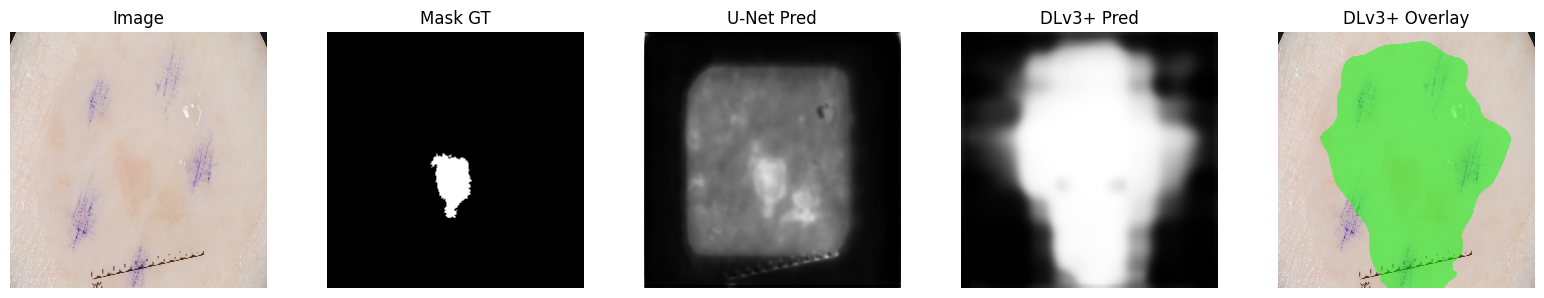

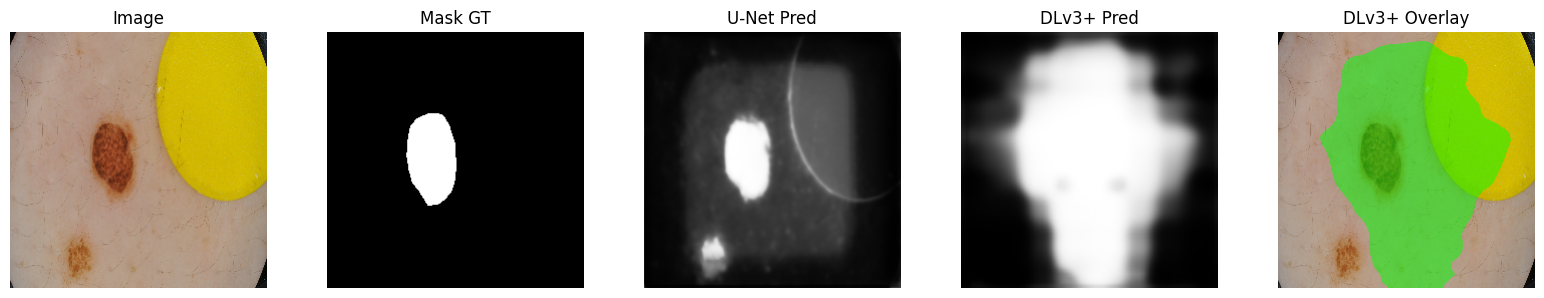

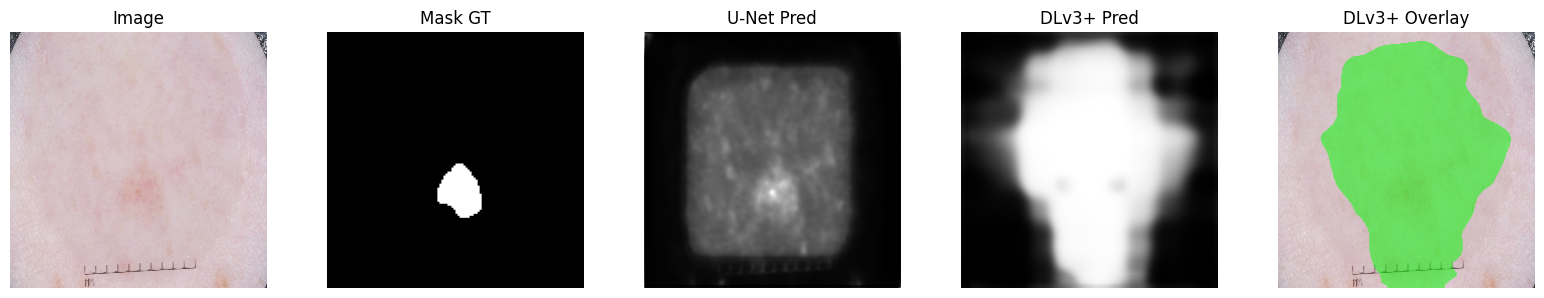

In [46]:
# step 6.6: side-by-side predictions
import numpy as np
import matplotlib.pyplot as plt

def compare_models_side_by_side(dataset, n=3, threshold=0.5):
    imgs, msks = next(iter(dataset))
    preds_base = model.predict(imgs)
    preds_dlv3 = dlv3p.predict(imgs)

    n = min(n, imgs.shape[0])
    for i in range(n):
        img = imgs[i].numpy()
        msk = msks[i].numpy()[..., 0]
        pred_b = preds_base[i, ..., 0]
        pred_d = preds_dlv3[i, ..., 0]

        fig, axes = plt.subplots(1, 5, figsize=(16, 3))
        axes[0].imshow(img); axes[0].set_title("Image"); axes[0].axis("off")
        axes[1].imshow(msk, cmap="gray"); axes[1].set_title("Mask GT"); axes[1].axis("off")
        axes[2].imshow(pred_b, cmap="gray"); axes[2].set_title("U-Net Pred"); axes[2].axis("off")
        axes[3].imshow(pred_d, cmap="gray"); axes[3].set_title("DLv3+ Pred"); axes[3].axis("off")

        # green overlays (thresholded)
        overlay = img.copy()
        overlay[(pred_d > threshold)] = 0.5*overlay[(pred_d > threshold)] + 0.5*np.array([0.0,1.0,0.0])
        axes[4].imshow(overlay); axes[4].set_title("DLv3+ Overlay"); axes[4].axis("off")

        plt.tight_layout(); plt.show()

compare_models_side_by_side(val_ds, n=3)

## 6.7 Notes
- If DeepLabV3+ gives better **Dice/IoU**, keep it as your main model.
- If U-Net is close or better, try:
  - More epochs
  - A bit more augmentation (flip + random rotate/crop)
  - Higher resolution (**384×384**) if time/resources allow